This is where the magic happens:

# MODELLING

In this notebook I'll work on a model to what a tourist will spend when vacationing in Tanzania.
The evaluation metric for the model is **Mean Absolute Error**.


This notenbook is WIP. There are some To do's on my list:
- add more comments to so far modelling steps
- feature selection/feature engineering, remove redundant columns
- check again outlier handling (check those with anomalies and find patterns)
- hyperparameter tuning
- fix overfitting
- error analysis
- interpretation/visualization

In [1]:
# import some packages that I'll need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from verstack.stratified_continuous_split import scsplit

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# set color scheme
cpal = ["#f94144","#f3722c","#f8961e","#f9844a","#f9c74f","#90be6d","#43aa8b","#4d908e","#577590","#277da1"]

# seaborn theme
sns.set()

# use natural numbers
pd.options.display.float_format = "{:.2f}".format

# set random seed
RSEED = 42

In [2]:
# load data
TZA = pd.read_csv('data/Train.csv')

# load subregions
subregions = pd.read_csv('data/subregions.csv')
subregions.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
TZA.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing',
       'total_cost'],
      dtype='object')

## Train Test Split

I'm going to split the train and test data now, very in the beginning to avoid data leakage.

I'm not using the sklearn train test split as I had concerning results in the first run (much better performance on test than on train data, I assume the different values of the target variable weren't well splitted). That's why I use Verstack stratified continuos split which allows me to stratify by continuos target variable. (It makes sure that different bins of total_cost are evenly divided among train and test data).

In [4]:
# train test split
train, test = scsplit(TZA, stratify = TZA['total_cost'], test_size = 0.3, random_state = RSEED)

## Preprocessing

I am going to preprocess the data now. I'll do it separately for train and test data. I start with the very basics for my Baseline Model.

#### Missing values and minor adjustments

In [5]:
# function to handle missing data and to make some basic adjustments on the dataset

def basic_preprocessing_baseline(df):
    # fill NaN total_male/total_female with 0
    df['total_male'] = df['total_male'].fillna(0)
    df['total_female'] = df['total_female'].fillna(0)
    
    # fill NaN travel_with with missing
    df['travel_with'] = df['travel_with'].fillna('missing')
    
    # fill NaN most_impressing with "No comments"
    df['most_impressing'] = df['most_impressing'].fillna('No comments')
   
    # drop id column
    df = df.drop(['ID'], axis =1)
    
    return df

In [6]:
# apply function on train data
train_bl = basic_preprocessing_baseline(train)
# apply function on test data
test_bl = basic_preprocessing_baseline(test)

In [7]:
# separate target variable, both in train and test data

X_train_bl = train_bl.drop(['total_cost'], axis=1)
y_train_bl = train_bl['total_cost']

X_test_bl = test_bl.drop(['total_cost'], axis=1)
y_test_bl = test_bl['total_cost']

### Build Pipelines

I'm going to build some pipelines now. They'll make modelling easier and faster.

I start with a pipeline for the categorical features. I use a One Hot Encoder to convert them into numbers.

In [8]:
# create list of categorical features
cat_features_bl = list(X_train_bl.columns[X_train_bl.dtypes==object])

# build pipeline
cat_pipeline_bl = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown= 'ignore', drop = 'first'))
])

For the numerical features I'll use a Robust Scaler. It can handle outliers pretty good.

In [9]:
# create list of numerical features
num_features_bl = list(X_train_bl.columns[X_train_bl.dtypes!=object])

# build pipeline
num_pipeline_bl = Pipeline([
    ('rob_scaler', RobustScaler())
])

In [10]:
# combine both pipelines in a preprocessor
preprocessor_bl = ColumnTransformer([
    ('num', num_pipeline_bl, num_features_bl),
    ('cat', cat_pipeline_bl, cat_features_bl)
])

### Baseline Model

First I'm going to train a linear regression model. Except for some NaN imputations and the basic preprocessing we haven't made adjustments on the data yet. The result of the Baseline Model will serve me as a benchmark.

In [11]:
# build pipeline that combines the preprocessor and the linear regression model
pipe_linreg_bl = Pipeline([
    ('preprocessor', preprocessor_bl),
    ('linreg', LinearRegression())
])

In [12]:
# cross validate to check how the model performs on the train data
y_train_predicted_bl_cv = cross_val_predict(pipe_linreg_bl, X_train_bl, y_train_bl, cv=100)

# print MAE of Baseline Model (train data)
print("Mean Absolute Error Baseline Model (train data): {:.2f}".format(mean_absolute_error(y_train_bl, y_train_predicted_bl_cv)))

Mean Absolute Error Baseline Model (train data): 5860776.55


In [13]:
# fit the actual model
y_train_predicted_bl = pipe_linreg_bl.fit(X_train_bl, y_train_bl)

# make predictions for the test data
y_test_predicted_bl = pipe_linreg_bl.predict(X_test_bl)
# print MAE of Baseline Model (test data)
print("Mean Absolute Error Baseline Model (test data): {:.2f}".format(mean_absolute_error(y_test_bl, y_test_predicted_bl)))

Mean Absolute Error Baseline Model (test data): 5896644.58


#### Interpretation

The Mean Absolute Error of the Baseline Model is 5896644.58 Tanzanian Schillig TZS.
What does that mean?
The MAE is the sum of absolute errors divided by the sample size $n$ where $y_i$ is the prediction and $x_i$ is the true value:

$$ 
MAE = \frac {\sum_{i=1}^n \vert y_i - x_i \vert} {n}
$$

The MAE uses the same scale as the data, so in this case TZS. 

So, on average, the model's predictions are 5896644.58 TZS off the true value. This is roughly 2173 Euro and seems quite a lot. 

Our aim is to improve (lower) this metric as much as we can.

So let's start with the actual 

### Modelling

First I'll make some more adjustments on the dataset - some of them we already saw in the EDA. I want to reduce noise from the dataset and add some more information which seems useful to me. I need a function that I can apply to both the train and the test data.

In [14]:
''' THIS FUNCTION IS STILL UNDER CONSTRUCTION'''

# function to handle missing data and to make some adjustments in the data set 

def adjustments1(df):
    # fill NaN total_male/total_female with 0
    df['total_male'] = df['total_male'].fillna(0)
    df['total_female'] = df['total_female'].fillna(0)
    
    # add a column group_size based on total_male/total_female
    df['group_size'] = df['total_female'] + df['total_male']
    
    # fill NaN travel_with with "Alone" if group_size is one
    df.loc[df.group_size == 1, 'travel_with'] = 'Alone'
    
    # fill remaining NaN travel_with with missing
    df['travel_with'] = df['travel_with'].fillna('missing')
    
    # fill NaN most_impressing with "No comments"
    df['most_impressing'] = df['most_impressing'].fillna('No comments')
    
    # add a column total_nights based on night_zanzibar/night_mainland
    df['total_nights'] = df['night_zanzibar'] + df['night_mainland']
    
    # handle group_size equals zero: either replace by 1 if alone traveller or median group size of the train data
    df.loc[(df.group_size == 0) & (df.travel_with == 'Alone'), 'group_size'] = 1
    df.loc[df.group_size == 0, 'group_size'] = train['group_size'].median()

    # handle total_nights equals zero: replace by median total_nights of the train data
    df.loc[df.total_nights == 0, 'total_nights'] = train['total_nights'].median()

    # drop id column
    df = df.drop(['ID'], axis =1)
    
    # drop night_mainland column (to avoid multicollinearity)
    df = df.drop(['night_mainland'], axis =1)
    
    # drop total_male column (to avoid multicollinearity)
    df = df.drop(['total_male'], axis =1)

    # add subregions just as in the EDA
    df['country'] = df['country'].str.lower()
    df = df.replace({'country' : {'united states of america': 'united States', 'swaziland' : 'eswatini', 'cape verde' : 'cabo verde', 'swizerland' : 'switzerland', 'ukrain' : 'ukraine','malt' : 'malta', 'burgaria' : 'bulgaria', 'korea' : 'south korea', 'comoro' : 'comoros', 'scotland' : 'united kingdom', 'russia' : 'russia', 'srilanka': 'sri lanka'}})
    df = df.replace({'country' : {'ivory coast': "côte d'ivoire", 'drc' : 'congo', 'uae' : 'united arab emirates', 'trinidad tobacco' : 'trinidad and tobago', 'costarica' : 'costa rica', 'philipines' : 'philippines', 'djibout' : 'djibouti', 'morroco' : 'morocco'}})
    df['country'] = df['country'].str.capitalize()
    df = pd.merge(df, subregions, how ='left')
    
    return df

In [15]:
# apply to train and test data
train_model = adjustments1(train)
test_model = adjustments1(test)

We have some outliers in the numeric columns, including our target variable. I want to get rid of them and try (for the first time) an outlier detection algorithm:

### Outlier handling: Isolation Forest

In this first iteration I'll use the Isolation Forest to detect anomalies and I'll then delete these observations. (Possibly I'll handle this differently in another iteration.) It is important that we apply this method to the train data only. Outliers in the test data remain untouched.
The Isolation Forest will not instantly delete the columns, but give a score for each row: either -1 (anomaly) or 1 (normal)

In [16]:
# create a dataframe with only numeric columns
iso_features = train_model[['total_female', 'night_zanzibar', 'total_cost', 'group_size',
       'total_nights']]

# have a look
iso_features

,total_female,night_zanzibar,total_cost,group_size,total_nights
0,1.00,0.00,4233255.00,1.00,3.00
1,3.00,4.00,52377000.00,5.00,10.00
2,0.00,4.00,7458750.00,3.00,15.00
3,2.00,3.00,828750.00,3.00,3.00
4,1.00,0.00,2836662.50,2.00,7.00
...,...,...,...,...,...
3361,2.00,0.00,16112243.00,4.00,6.00
3362,1.00,0.00,3987945.00,1.00,12.00
3363,0.00,0.00,314925.00,1.00,3.00
3364,0.00,0.00,1560000.00,1.00,4.00


In [17]:
# check size of this data set
train_model.shape

(3366, 23)

In [18]:
# define isolation forest
isolation_forest = IsolationForest()

# fit isolation forest
isolation_forest.fit(iso_features)

# make predictions
predictions = isolation_forest.predict(iso_features)

# create data frame with Isolation Forest Scores
predictions_df = pd.DataFrame(predictions, columns = ['Iso_Score'])

# merge this data frame into the train_model data frame
train_model_iso = pd.concat([train_model, predictions_df], axis=1)

# keep only those with Iso_Score is 1 (normal)
train_model_iso = train_model_iso[train_model_iso['Iso_Score'] == 1]

# delete the Iso_Score column
train_model_iso = train_model_iso.drop(['Iso_Score'], axis =1)

In [19]:
# check size of data set without anomalies
train_model_iso.shape

(2936, 23)

In [20]:
df_iso = pd.concat([train_model, predictions_df], axis=1)

In [21]:
df_iso[df_iso['Iso_Score'] == -1]

,country,age_group,travel_with,total_female,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,...,package_insurance,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,group_size,total_nights,sub_region,Iso_Score
1,Germany,45-64,Spouse and Children,3.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,Yes,Yes,...,Yes,4.00,Cash,Yes,Friendly People,52377000.00,5.00,10.00,Western Europe,-1
16,Zimbabwe,25-44,Friends/Relatives,3.00,Leisure and Holidays,Beach tourism,"Travel, agent, tour operator",Independent,No,No,...,No,0.00,Cash,Yes,Good service,497250.00,3.00,6.00,Sub-Saharan Africa,-1
39,Kenya,1-24,missing,11.00,Visiting Friends and Relatives,Hunting tourism,"Friends, relatives",Independent,No,No,...,No,0.00,Cash,Yes,No comments,547404.00,11.00,2.00,Sub-Saharan Africa,-1
56,France,25-44,Spouse and Children,2.00,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Package Tour,Yes,Yes,...,No,14.00,Cash,Yes,No comments,20553000.00,4.00,21.00,Western Europe,-1
57,Australia,25-44,Friends/Relatives,3.00,Leisure and Holidays,Conference tourism,"Travel, agent, tour operator",Independent,No,No,...,No,4.00,Cash,Yes,Friendly People,49857928.50,3.00,14.00,Australia and New Zealand,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3315,United kingdom,1-24,Friends/Relatives,4.00,Volunteering,Hunting tourism,others,Independent,No,No,...,No,0.00,Cash,Yes,"Wonderful Country, Landscape, Nature",1479426.00,5.00,13.00,Northern Europe,-1
3321,Austria,1-24,Friends/Relatives,2.00,Volunteering,Cultural tourism,others,Independent,No,No,...,No,25.00,Cash,Yes,Friendly People,9945000.00,2.00,42.00,Western Europe,-1
3323,Germany,25-44,Spouse,1.00,Leisure and Holidays,Conference tourism,others,Independent,No,No,...,No,17.00,Cash,Yes,Friendly People,14917500.00,2.00,47.00,Western Europe,-1
3325,Spain,25-44,Friends/Relatives,4.00,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Package Tour,No,Yes,...,No,5.00,Cash,Yes,Wildlife,3646500.00,4.00,8.00,Southern Europe,-1


430 observations were deleted. We might find a better way for the outlier handling later.

I'm now going to use a 

### Random Forest Regressor

I start with a Random Forest because I made good experiences with it.

In [22]:
# define target variable

X_train = train_model_iso.drop(['total_cost'], axis=1)
y_train = train_model_iso['total_cost']

X_test = test_model.drop(['total_cost'], axis=1)
y_test = test_model['total_cost']

In [23]:
# build pipeline

cat_features = list(X_train.columns[X_train.dtypes==object])

cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown= 'ignore', drop = 'first'))
])

num_features = list(X_train.columns[X_train.dtypes!=object])

num_pipeline = Pipeline([
    ('stand_scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
])

pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('randfor', RandomForestRegressor(random_state=RSEED))
])

In [24]:
# cross validate

y_train_predicted_rf_cv = cross_val_predict(pipe_rf, X_train, y_train, cv=5)
print("Mean Absolute Error first Random Forest (cross validation): {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_rf_cv)))

Mean Absolute Error first Random Forest (cross validation): 3522660.33


In [25]:
# fit and predict

pipe_rf.fit(X_train, y_train)

y_train_predicted_rf = pipe_rf.predict(X_train)
y_test_predicted_rf = pipe_rf.predict(X_test)
print("Mean Absolute Error first Random Forest (train data): {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_rf)))
print("Mean Absolute Error first Random Forest (test data): {:.2f}".format(mean_absolute_error(y_test, y_test_predicted_rf)))

Mean Absolute Error first Random Forest (train data): 1337888.39
Mean Absolute Error first Random Forest (test data): 5034041.91


We see here some heavy overfitting to the train data. This is not surprising because we're currently still working with ALL features in the dataset and we haven't applied feature engineering techniques yet. So there's still too much noise. We'll work on this soon. First I'd like to try some other models just to see which of them handles the data best. For this we only have to create new pipelines and fit the models.

### Decision Tree

In [26]:
# pipeline

pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('dectree', DecisionTreeRegressor(random_state=RSEED))
])

# cross validate

y_train_predicted_dt_cv = cross_val_predict(pipe_dt, X_train, y_train, cv=5)
print("Mean Absolute Error first Decision Treee (cross validation): {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_dt_cv)))

Mean Absolute Error first Decision Treee (cross validation): 4684275.43


In [27]:
# fit and predict

pipe_dt.fit(X_train, y_train)

y_train_predicted_dt = pipe_dt.predict(X_train)
y_test_predicted_dt = pipe_dt.predict(X_test)
print("Mean Absolute Error first Decision Tree (train data): {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_dt)))
print("Mean Absolute Error first Decision Tree (test data): {:.2f}".format(mean_absolute_error(y_test, y_test_predicted_dt)))

Mean Absolute Error first Decision Tree (train data): 73628.05
Mean Absolute Error first Decision Tree (test data): 6004363.30


### KNN

In [28]:
# pipeline

pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor())
])

# cross validate

y_train_predicted_knn_cv = cross_val_predict(pipe_knn, X_train, y_train, cv=5)
print("Mean Absolute Error first KNN (cross validation): {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_knn_cv)))

Mean Absolute Error first KNN (cross validation): 3731425.39


In [29]:
# fit and predict

pipe_knn.fit(X_train, y_train)

y_train_predicted_knn = pipe_knn.predict(X_train)
y_test_predicted_knn = pipe_knn.predict(X_test)
print("Mean Absolute Error first KNN (train data): {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_knn)))
print("Mean Absolute Error first KNN (test data): {:.2f}".format(mean_absolute_error(y_test, y_test_predicted_knn)))

Mean Absolute Error first KNN (train data): 3011228.11
Mean Absolute Error first KNN (test data): 5105256.23


### XGB

In [30]:
# pipeline

pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor())
])

# cross validate

y_train_predicted_xgb_cv = cross_val_predict(pipe_xgb, X_train, y_train, cv=5)
print("Mean Absolute Error first XGB (cross validation): {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_xgb_cv)))

Mean Absolute Error first XGB (cross validation): 3723322.28


In [31]:
# fit and predict

pipe_xgb.fit(X_train, y_train)

y_train_predicted_xgb = pipe_xgb.predict(X_train)
y_test_predicted_xgb = pipe_xgb.predict(X_test)
print("Mean Absolute Error first XGB (train data): {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_xgb)))
print("Mean Absolute Error first XGB (test data): {:.2f}".format(mean_absolute_error(y_test, y_test_predicted_xgb)))

Mean Absolute Error first XGB (train data): 1808278.77
Mean Absolute Error first XGB (test data): 5217924.23


We can see that all models have a serious problem with overfitting. On the test data they perform quite similarly.

We now have to reduce the noise in the data set and start with

### Feature engineering, feature selection

First, I want to understand the Tour Arrangements better to see if I can drop some columns here.
I want to check whether there are tour_arrangement == 'Package Tour' which do not have a 'Yes' in any of the package_xxx columns - if not or not many, the tour_arrangements column could be deleted entirely because it's seemingly redundant.

In [32]:
X_train[(X_train['tour_arrangement'] == 'Package Tour') & (X_train['package_transport_int'] == 'No') & (X_train['package_accomodation'] == 'No') & (X_train['package_food'] == 'No') & (X_train['package_transport_tz'] == 'No') & (X_train['package_sightseeing'] == 'No') & (X_train['package_guided_tour'] == 'No') & (X_train['package_insurance'] == 'No')]

,country,age_group,travel_with,total_female,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,...,package_sightseeing,package_guided_tour,package_insurance,night_zanzibar,payment_mode,first_trip_tz,most_impressing,group_size,total_nights,sub_region
541,Kenya,45-64,Alone,0.00,Volunteering,Hunting tourism,others,Package Tour,No,No,...,No,No,No,0.00,Cash,No,Friendly People,1.00,2.00,Sub-Saharan Africa
2256,Sweden,1-24,missing,1.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,No,No,...,No,No,No,7.00,Cash,Yes,Good service,2.00,39.00,Northern Europe
2794,United states,45-64,Spouse and Children,1.00,Leisure and Holidays,Beach tourism,"Travel, agent, tour operator",Package Tour,No,No,...,No,No,No,5.00,Credit Card,Yes,Friendly People,3.00,5.00,Northern America
3131,India,25-44,Alone,0.00,Other,Hunting tourism,"Travel, agent, tour operator",Package Tour,No,No,...,No,No,No,0.00,Cash,Yes,Friendly People,1.00,3.00,Southern Asia


We see that there are only 4 columns in the train data where the mentioned conditions apply. I think we can safely delete the tour_arrangement column.

Some more ideas how to reduce the noise in the dataset:

- remove the following columns entirely since they're too strongly connected to other columns or were shown in the EDA to have very low impact:
  - country (we use sub-region instead)
  - remove the total_female column (too much noise)
  - remove the travel_with column since it contains a lot of "missing" values and assumpions from my side. I tend to believe that group_size is more meaningful
  - info_source (it was shown in the EDA that only one of the possible responses has an impact: if info source was tour operator - this info should be covered by tour_arrangement column)
  - most_impressing (no impact in EDA, too many missing values anyway)
- possibly bin the total nights (as in EDA)

feature importance

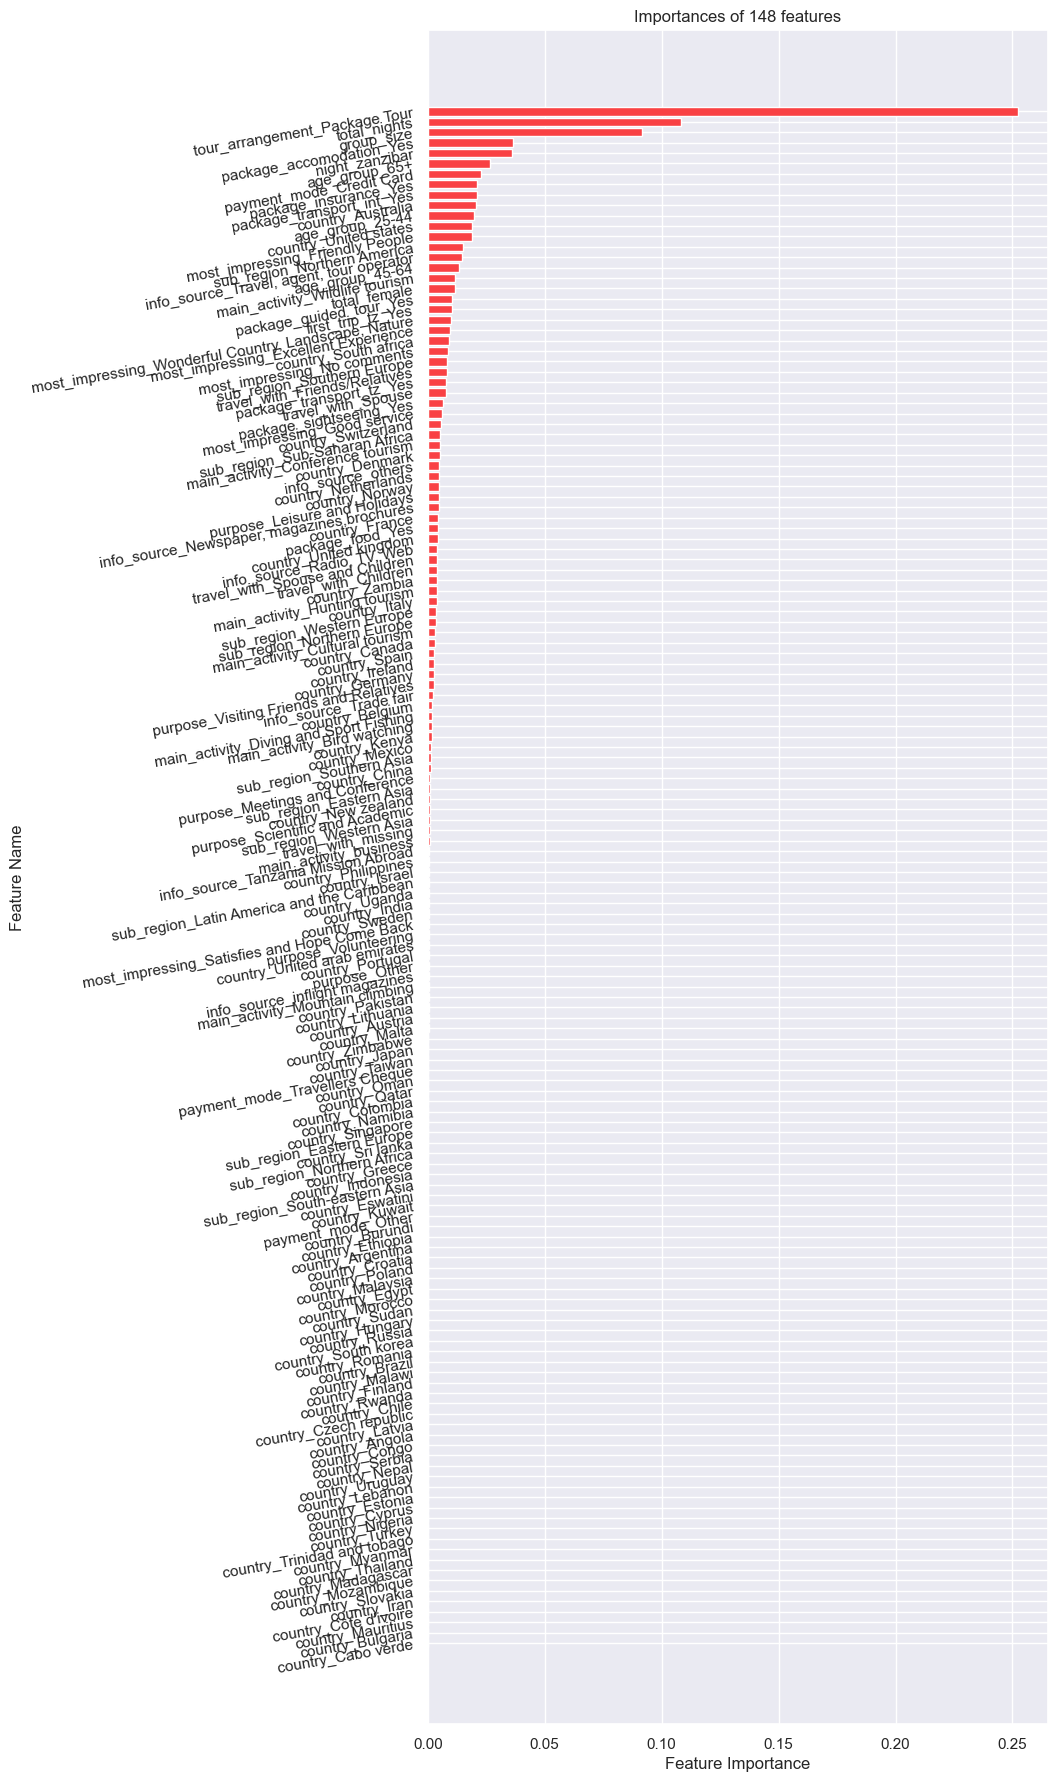

In [33]:
encoded_cat_features = pipe_rf['preprocessor'].transformers_[1][1]\
    ['1hot'].get_feature_names_out(cat_features)
feature_names = np.insert(encoded_cat_features,0, num_features)
importances = pipe_rf.steps[1][1].feature_importances_
sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]
num_features_to_display = len(importances)
top_feature_names = sorted_feature_names[:num_features_to_display]
top_importances = sorted_importances[:num_features_to_display]
plt.figure(figsize=(8, 22))  
plt.barh(top_feature_names, top_importances, color='#f94144')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.yticks(rotation=10)
plt.title('Importances of {} features'.format(num_features_to_display))
plt.gca().invert_yaxis() 
plt.show();

One of the columns I wanted to remove is the most important feature for the model. But this does not mean, that this is *really* the most important feature. Since the model is still performing poorly it could well be the case that it is overrating this feature. So I'll definitely try the model without this one.

As we can see: countries are not too important for the model. So I can safely delete this feature (which I planned anyway) - the subregion seems to be the better feature here.

The total_nights are quite important for the model, too, but I'd like to stick to my plan to bin these numbers.

In [34]:
# function to perform the mentioned changes

def adjustments2(df):
    # drop country column
    df = df.drop(['country'], axis =1)
    
    # drop tour_arrangement column
    df = df.drop(['tour_arrangement'], axis =1)
    
    # drop total_female column
    df = df.drop(['total_female'], axis =1)

    # drop group_size column
    df = df.drop(['group_size'], axis =1)

    # drop info_source column
    df = df.drop(['info_source'], axis =1)

    # drop most_impressing column
    df = df.drop(['most_impressing'], axis =1)

    # bin total_nights and night_zanzibar columns
    bins = [-1,0,7,14,21,28,56,1000]
    labels = ['none','up to 1 week', '1-2 weeks', '2-3 weeks', '3-4 weeks', '4-8 weeks', 'more than 8 weeks']
    bins_total = [0,7,14,21,28,56,1000]
    labels_total = ['up to 1 week', '1-2 weeks', '2-3 weeks', '3-4 weeks', '4-8 weeks', 'more than 8 weeks']
    df['nights_zanzibar_binned'] = pd.cut(df['night_zanzibar'], bins=bins, labels=labels)
    df['total_nights_binned'] = pd.cut(df['total_nights'], bins=bins_total, labels=labels_total)

    # delete total_nights and nights_zanzibar columns
    df = df.drop(['total_nights'], axis =1)
    df = df.drop(['night_zanzibar'], axis =1)

    df['nights_zanzibar_binned'] = df['nights_zanzibar_binned'].astype('object')
    df['total_nights_binned'] = df['total_nights_binned'].astype('object')

    return df

### Hyperparameter tuning

In [35]:
# define parameters to test
param_rf_all = {'randfor__n_estimators':[100, 500, 1000, 1500, 2000],
                'randfor__min_samples_split': [2, 5, 10, 15, 20],
                'randfor__max_depth': [10,20,50,80,100],
                'randfor__max_features': [1.0, 'sqrt'],
                'randfor__min_samples_leaf' : [1,2,4],
                'randfor__bootstrap': [True, False],
              }

In [36]:
# grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf_all, cv=5, scoring='neg_mean_absolute_error', 
#                           verbose=5, n_jobs=-1)

# run grid search
# grid_rf.fit(X_train, y_train)